# A passive neuron as a low-pass filter

The neuron model is based on the RC circuit in NEURON.  

## Step 1: Setup

In [1]:
# Setup inline plotting
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# For Google Colab, this line installs NEURON
!pip install neuron quantities

In [2]:
# We will let this library handle unit conversion for us
import quantities as pq
from quantities import um, nS, mV, cm, ms, nA, S, uF, Hz, degrees, s

In [3]:
# Import and initialize NEURON
import neuron
from neuron import h
h.load_file("stdrun.hoc")

1.0

In [4]:
# Import other modules we need
import numpy as np

## Step 2: Define the circuit
We will use a single compartment, called a "Section" (more on that in next lectures). <br>
It has a cylindrical geometry with length "L" and a diameter "diam", and a specific capacitance "cm" (capacitance per area) <br>
**Unit conversion is a common source of error, so we will be explicit with our units.** 

In [5]:
soma = h.Section()

### Query NEURON for the expected units for soma.L & soma.diam

In [6]:
[h.units(x) for x in ["L", "diam"]]

['um', 'um']

In [7]:
soma.L = 30 * um
soma.diam =  30 * um

In [8]:
volume = soma(0.5).volume() * um**3

In [9]:
area = soma(0.5).area() * um**2

### Assign the membrane capacitance "everywhere"

In [10]:
h.units("cm")  # Query the expected units

'uF/cm2'

In [11]:
specific_membrane_capacitance = 1 * uF/cm**2

In [12]:
for sec in soma.wholetree():
    sec.cm = specific_membrane_capacitance #  specific membrane capacitance (micro Farads / cm^2)

### Add (insert) a leak conductance G = 1/R

In [13]:
soma.insert("pas")

__nrnsec_0x55c20bdfc210

In [14]:
h.units("g_pas")

'S/cm2'

In [15]:
G = 5 * nS  # R = 1/G in our RC circuit

In [16]:
v_rest = -70*mV

In [17]:
# Assign the leak conductance everywhere
for seg in soma:
    seg.pas.g = (G/area).rescale(S/cm**2)  # Compute specific conductance, and rescale to units of 'S/cm2'
    seg.pas.e = v_rest

### Add a current injection

In [18]:
stim = h.IClamp(soma(0.5))

In [19]:
stim.delay = 0 * ms  # Inject current 500ms after the start of the simulation 
stim.dur = 1500 * ms  # stop injecting current at 520ms 
stim.amp = 0.1 * nA  # Inject 0.1 nA of current

### Add a sinusoidal current of frequency $f$

In [20]:
t_current = np.arange(0,1500,h.dt)*ms

In [21]:
# Using pq.sin instead of np.sin handles time units for you 
f = 2*Hz
I_amp = 0.1 * nA
I_t = I_amp * pq.sin(2*np.pi*f*t_current)

Text(0, 0.5, 'current (nA)')

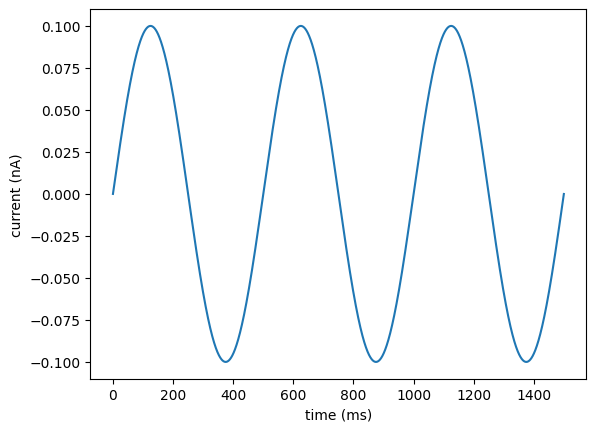

In [22]:
plt.plot(t_current, I_t)
plt.xlabel("time (ms)")
plt.ylabel("current (nA)")

In [23]:
v_I_t = h.Vector(I_t)
v_t_current = h.Vector(t_current)

In [25]:
# Apply the time-varying current to the IClamp amplitude parameter
v_I_t.play(stim._ref_amp, v_t_current, True)

Vector[0]

## Step 3: Run the simulation

### Define recordings of simulation variables

In [26]:
soma_v = h.Vector().record(soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

### Set the initial voltage

In [27]:
h.finitialize( float(v_rest) )

1.0

### Run the simulation for 1500ms

In [28]:
h.continuerun( float(1500 * ms) )

0.0

In [29]:
# What would be the voltage trace if it relaxed immediately to V_infinity (i.e. tau->0)
# This can be computed by I*R_input + V_rest as discussed in the lecture.
adiabatic_V = (I_t/G).rescale(mV)+v_rest

## Step 4: Plot the results

Text(0.5, 1.0, 'Current injection at f=2.000000 Hz')

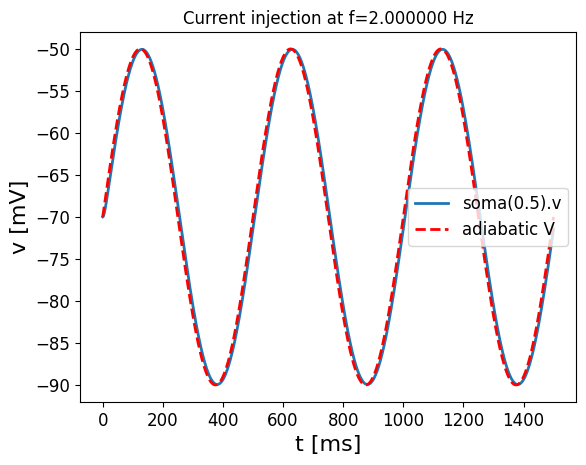

In [30]:
plt.plot(t, soma_v, lw=2, label="soma(0.5).v")
plt.plot(t_current, adiabatic_V, 'r--', lw=2, label="adiabatic V")
plt.legend(fontsize=12)
plt.xlabel("t [ms]", size=16)
plt.ylabel("v [mV]", size=16)
plt.xticks(size=12)
plt.yticks(size=12)
plt.title("Current injection at f=%f Hz" % f)

In [31]:
(np.max(soma_v.to_python()) - np.min(soma_v.to_python()))/2

19.94947166808773

In [32]:
# Computing adiabatic amplitude of voltage oscillations from input resistance Rin = 1/G
(I_amp / G).rescale(mV)

array(20.) * mV

In [33]:
def compute_amp_ratio(soma_v, adiabatic_v_amp):
    # TODO - should probably throw away a first relaxation time of 200-500ms
    soma_amp = (np.max(soma_v.to_python()) - np.min(soma_v.to_python()))/2
    return soma_amp / adiabatic_v_amp

In [34]:
def compute_phase_lag(soma_v, t, period):
    """ Return phase lag in degrees """
    # TODO - should probably throw away a first relaxation time of 200-500ms
    arr_t, arr_v = np.array(t), np.array(soma_v)
    # find time index of 1 period
    idx = arr_t.searchsorted(period)
    # find peak within 1 period
    idx_peak = np.argmax(arr_v[:idx])
    t_peak = arr_t[idx_peak]
    return (t_peak*ms - period/4) / period * 360 * degrees

In [35]:
compute_amp_ratio(soma_v, (I_amp / G).rescale(mV))

array(0.99747358) * 1/mV

There is a nice agreement between the amplitude of membrane voltage fluctuation, and the adiabatic amplitude given by $I(t)*R_{in}$, as can be seen in the plot above!

What about the phase of the oscillations?

In [36]:
period = (1/f).rescale(ms)

In [37]:
period

array(500.) * ms

In [38]:
compute_phase_lag(soma_v,t, period)

array(4.068) * deg

The voltage oscillations follow closely the adiabatic oscillation given by $I(t)*R_{in}$, as can be seen in the plot above!

### Now let's increase f. Can the membrane "follow" higher frequencies? 

In [39]:
# Using pq.sin instead of np.sin handles time units for you 
f = 50*Hz
I_amp = 0.1 * nA
I_t = I_amp * pq.sin(2*np.pi*f*t_current)

In [40]:
# Preserve v_I_t object in memory, but fill it with new current values
v_I_t.from_python(I_t)

Vector[0]

In [41]:
h.finitialize( float(v_rest) )
h.continuerun( float(1500 * ms) )

0.0

In [42]:
adiabatic_V = (I_t/G).rescale(mV)+v_rest

Text(0.5, 1.0, 'Current injection at f=50.000000 Hz')

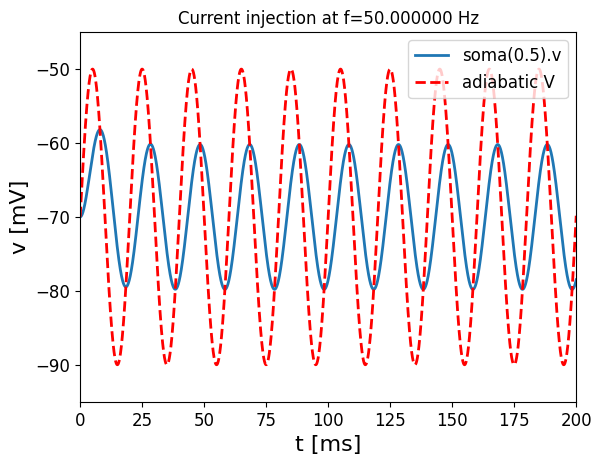

In [43]:
plt.plot(t, soma_v, lw=2, label="soma(0.5).v")
plt.plot(t_current, adiabatic_V, 'r--', lw=2, label="adiabatic V")
plt.axis([0, 200, -95, -45])
plt.legend(fontsize=12)
plt.xlabel("t [ms]", size=16)
plt.ylabel("v [mV]", size=16)
plt.xticks(size=12)
plt.yticks(size=12)
plt.title("Current injection at f=%f Hz" % f)

In [44]:
compute_amp_ratio(soma_v, (I_amp / G).rescale(mV))

array(0.54007415) * 1/mV

In [45]:
period = (1/f).rescale(ms)

In [46]:
period

array(20.) * ms

In [47]:
compute_phase_lag(soma_v,t, period)

array(54.) * deg

Now the voltage oscillations are having trouble keeping up! They trail the adiabatic oscillation given by $I(t)*R_{in}$ by more than a quarter period (45 degrees), as can be seen in the plot above.

### Cut-off frequency of a low-pass filter

The cut-off fequency, $f_c$, is defined as the frequency where the amplitude of the $v_m$ oscillations is 70.7% of the adiabatic voltage $I_{stim}*R_{in}$ and where the phase of the oscillations lags by 1/8th of an oscillation period (45 degrees or $\pi/4$).

From circuit analysis, we expect that $f_c = 1/2\pi \tau_m$

![low-pass filter diagram could not be fetched](https://www.electronics-tutorials.ws/wp-content/uploads/2018/05/filter-fil10.gif)

In [48]:
# Converting a voltage ratio of 70.7% to dB
20 * np.log10(0.707)

-3.0116117240620124

## Now it's your turn!

### **Question 1** 
Find the cut-off frequency of the membrane using the expression above.


In [49]:
g_L = (G/area).rescale(S/cm**2)

In [50]:
g_L

array(0.00017684) * S/cm**2

In [51]:
tau_m = (specific_membrane_capacitance/g_L).rescale(s)

In [54]:
# Fill in the rest ... What is the numerical value of f_c?
f_c = 1/2/np.pi

### **Question 2**
Plot the phase and attenuation = $V_m / V_{\infty}$ for a range of frequencies around $f_c$.  Does an attenuation of $\approx 70.7%$ and phase lag of 1/8th the period occur at $f_c$? Visualize the voltage traces for $f = f_c$, $f = 1/10 * f_c$ (low frequency) and $f = 10 * f_c$ (high frequency).<br>
<br>
**Hint**: You should use a *for* loop, and the **compute_amp_ratio** and **compute_phase_lag** functions above. For re-running the simulation, follow the example "Now let's increase f."

**Hint**: Below is an example of a for loop collecting values in a list, and plotting them

In [57]:
# A function to square a number
def compute_square(x):
    return x*x

In [68]:
# Make an empty list to store values
result_list = []

In [69]:
# Frequency range
freqs = np.arange(0,100,0.1)

In [70]:
for x in freqs:
    result = compute_square(x)
    # Append the result to the result_list
    result_list.append(result) 

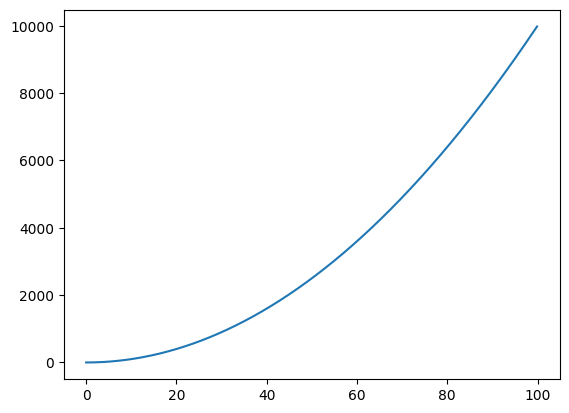

In [71]:
# plot(x, y)
plt.plot(freqs, result_list)